In [ ]:
#open in google colab
#eggplant,mushroom,cucumber image recognition and localization....

import xml.etree.ElementTree as ET
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import tensorflow as tf
constant=255

In [ ]:
#plots bounding box on a image...

def bounding(img,axis):
    amin=(axis[0],axis[1])
    amax=(axis[2],axis[3])
    img=cv2.rectangle(img,amin,amax,(255,0,0),5)
    plt.imshow(img)
    plt.plot()


In [ ]:
#accuracy threshold

class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["box_out_accuracy"]
        if accuracy >= self.threshold:
            self.model.stop_training = True

In [ ]:
#image extraction
def image(path,name):
    img_out=np.zeros((3))
    array=['cucumber','eggplant','mushroom']
    for i in range(len(array)):
        if (name==array[i]):
            img_out[i]=1
    img=cv2.imread(path)
    return img,img_out

In [ ]:
# bounding box data extraction
def box_parser(path):
    box=[]
    tree = ET.parse(path)
    root = tree.getroot()
    for type_tag in root.findall('object/bndbox/'):
        box.append(int(type_tag.text))
    return box


In [ ]:
#generating the data
img_out=[]
box_out=[]
x_train=[]
path='/content/drive/My Drive/Localization/training_images/training_images'
names=os.listdir(path)
for name in tqdm(names):
    if (name[-3:]=='jpg'):
        img,y=image(os.path.join(path,name),name.split('_')[0])
        x_train.append(img)
        img_out.append(y)
    else:
        box=box_parser(os.path.join(path,name))
        box_out.append(box)
img_out=np.array(img_out)#.reshape(-1,3,1)
box_out=np.array(box_out)#.reshape(-1,4,1)
x_train=np.array(x_train)

    

100%|██████████| 372/372 [00:00<00:00, 530.17it/s]


In [ ]:
#bounding normalization

def normalization(matrix):
  matrix=(matrix)/constant
  return matrix
    


In [ ]:
box_out=normalization(box_out)
print(x_train.shape)
print(img_out.shape)
print(box_out.shape)

(186, 227, 227, 3)
(186, 3)
(186, 4)


In [ ]:
#creating a model
img_inputs = tf.keras.Input(shape=(227, 227,3))
conv=tf.keras.layers.Conv2D(32,(3,3),padding='same',input_shape=(227,227,3),activation='relu')
x=conv(img_inputs)
x=tf.keras.layers.MaxPooling2D(2,2)(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Conv2D(32,(3,3),padding='same',activation='relu')(x)
x=tf.keras.layers.MaxPooling2D(2,2)(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Conv2D(64,(3,3),padding='same',activation='relu')(x)
x=tf.keras.layers.MaxPooling2D(2,2)(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Conv2D(64,(3,3),padding='same',activation='relu')(x)
x=tf.keras.layers.MaxPooling2D(2,2)(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Conv2D(128,(3,3),padding='same',activation='relu')(x)
x=tf.keras.layers.MaxPooling2D(2,2)(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Conv2D(128,(3,3),padding='same',activation='relu')(x)
x=tf.keras.layers.MaxPooling2D(2,2)(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Conv2D(128,(3,3),padding='same',activation='relu')(x)
x=tf.keras.layers.MaxPooling2D(2,2)(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Flatten()(x)
#output-1
o1=tf.keras.layers.Dense(1600,activation='relu')(x)
o1=tf.keras.layers.Dense(800,activation='relu')(o1)
o1=tf.keras.layers.Dense(40,activation='relu')(o1)
o1=tf.keras.layers.Dense(3,activation='softmax',name='image-out')(o1)
#output-2
o2=tf.keras.layers.Dense(160,activation='relu')(x)
o2=tf.keras.layers.Dense(20,activation='relu')(x)
o2=tf.keras.layers.Dense(4,activation='linear',name='box_out')(o2)

model = tf.keras.models.Model(inputs=img_inputs, outputs=[o1,o2])

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 227, 227, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 113, 113, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 113, 113, 32) 128         max_pooling2d[0][0]              
_______________________________________________________________________________________

In [ ]:
model.compile(optimizer='adam', loss=['categorical_crossentropy','mae'],metrics=['accuracy'])

In [ ]:
callback=MyThresholdCallback(threshold=0.9)  #accuracy threshold 0.9 (90%)
history=model.fit(x_train,[img_out,box_out],batch_size=16,epochs=300,callbacks=[callback],verbose=1)

Epoch 1/300
12/12 [==============================] - 1s 50ms/step - loss: 1.5025 - image-out_loss: 0.7346 - box_out_loss: 0.7680 - image-out_accuracy: 0.6989 - box_out_accuracy: 0.1882
Epoch 2/300
12/12 [==============================] - 0s 28ms/step - loss: 1.0146 - image-out_loss: 0.4759 - box_out_loss: 0.5387 - image-out_accuracy: 0.8548 - box_out_accuracy: 0.3495
Epoch 3/300
12/12 [==============================] - 0s 28ms/step - loss: 0.6255 - image-out_loss: 0.2636 - box_out_loss: 0.3619 - image-out_accuracy: 0.9140 - box_out_accuracy: 0.4140
Epoch 4/300
12/12 [==============================] - 0s 29ms/step - loss: 0.5072 - image-out_loss: 0.1895 - box_out_loss: 0.3177 - image-out_accuracy: 0.9301 - box_out_accuracy: 0.4516
Epoch 5/300
12/12 [==============================] - 0s 28ms/step - loss: 0.4249 - image-out_loss: 0.1443 - box_out_loss: 0.2806 - image-out_accuracy: 0.9355 - box_out_accuracy: 0.4516
Epoch 6/300
12/12 [==============================] - 0s 29ms/step - loss: 0

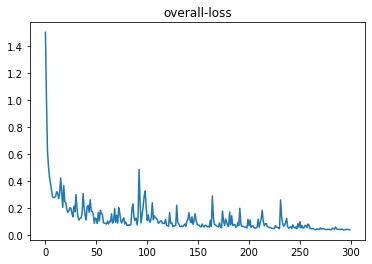

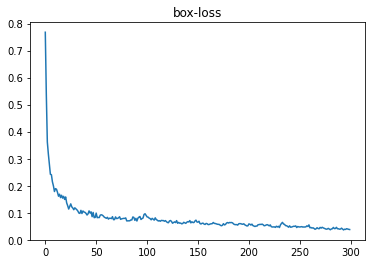

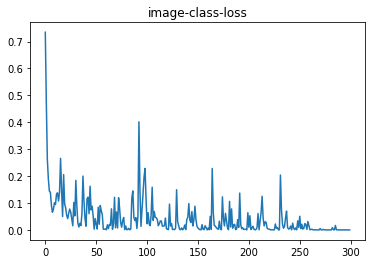

In [ ]:
plt.plot(history.history['loss'])
plt.title('overall-loss')
plt.show()
plt.plot(history.history['box_out_loss'])
plt.title('box-loss')
plt.show()
plt.plot(history.history['image-out_loss'])
plt.title('image-class-loss')
plt.show()

Saving eggplant_6.jpg to eggplant_6.jpg
PREDICTION:  eggplant
[[ 19.577246  67.278145 225.37376  144.63092 ]]


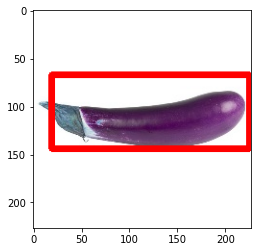

In [ ]:
#model testing... 
array=['cucumber','eggplant','mushroom']
from google.colab import files
from keras.preprocessing import image
uploaded=files.upload()
for fn in uploaded.keys():
  path=fn
  img=image.load_img(path,target_size=(227,227,3))
  img=cv2.imread(path)
  img=cv2.resize(img,(227,227))
  x=image.img_to_array(img)
  x=np.expand_dims(x,axis=0)
  images=np.vstack([x])
  image_pre,box_pre=model.predict(images)
  image_pre=image_pre.reshape(3)
  box_pre=(box_pre*constant)
  mx=max(image_pre)
  for i in range(len(image_pre)):
    if (image_pre[i]==mx):
      print('PREDICTION: ',array[i])
  print(box_pre)
  bounding(img,box_pre.reshape(4))
